# Import Statements

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

In [5]:
data = pd.read_csv("D:\\FYP\\AzureDatasetPacking2019\\Aggregated Data\\aggregated_vmtable_correct_dates.csv")

In [6]:
data["index"] = pd.to_datetime(data["index"])
data = data.set_index("index")
data = data[["vm_virtual_core_count"]]
data.drop(data.tail(1).index,inplace=True)

# Detrend the data

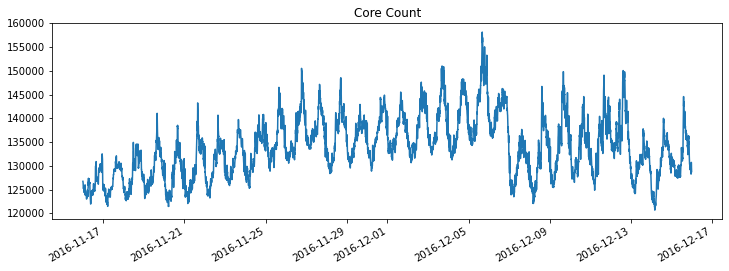

In [7]:
plt.figure(figsize=(12,4))
plt.plot(data)
plt.title("Core Count")
plt.gcf().autofmt_xdate()
plt.show()

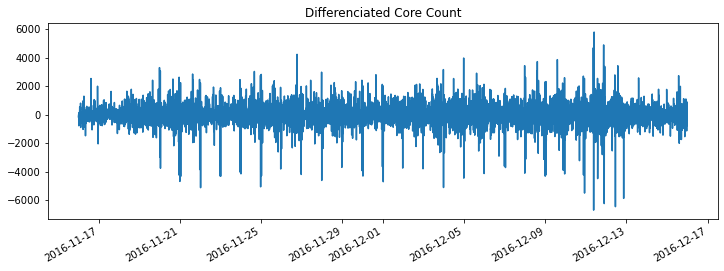

In [8]:
data = data.diff()
data = data.drop(data.head(1).index)

plt.figure(figsize=(12,4))
plt.plot(data)
plt.title("Differenciated Core Count")
plt.gcf().autofmt_xdate()
plt.show()

# Rolling Window DataFrame
## Window Length: 48 (4 hours)
VM Table Memory

In [1]:
col_names = ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", "x10", "x11", "x12", "x13", "x14",
              "x15", "x16", "x17", "x18", "x19", "x20", "x21", "x22", "x23", "x24", "x25", "x26", "x27",
              "x28", "x29", "x30", "x31", "x32", "x33", "x34", "x35", "x36", "x37", "x38", "x39", "x40",
              "x41", "x42", "x43", "x44", "x45", "x46", "x47", "x48"]

In [9]:
windows = 48

rw48_predictions = data.reset_index()

rw48_windows = pd.DataFrame([window.to_list() for window in data["vm_virtual_core_count"].rolling(window=windows+1)], 
                          columns =  col_names + ["extra"])

rw48_predictions = pd.merge(rw48_predictions, rw48_windows, left_index=True, right_index=True)
           
rw48_predictions.head()

,index,vm_virtual_core_count,x1,x2,x3,x4,x5,x6,x7,x8,...,x40,x41,x42,x43,x44,x45,x46,x47,x48,extra
0,2016-11-16 00:05:00,-45.0,-45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-11-16 00:10:00,-196.0,-45.0,-196.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-11-16 00:15:00,-114.0,-45.0,-196.0,-114.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-11-16 00:20:00,-137.0,-45.0,-196.0,-114.0,-137.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-11-16 00:25:00,-772.0,-45.0,-196.0,-114.0,-137.0,-772.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
rw48_predictions = rw48_predictions.drop(rw48_predictions.head(windows+1).index) # drop first rows with NAN values

In [11]:
rw48_predictions = rw48_predictions[["index", "vm_virtual_core_count"] + col_names]

In [12]:
train, test = train_test_split(rw48_predictions, test_size = 0.2, random_state= 1, shuffle=False)
train.shape, test.shape

((6871, 50), (1718, 50))

# Normalise the Data

In [13]:
scaler = MinMaxScaler()
train[["vm_virtual_core_count"] + col_names] = scaler.fit_transform(train[["vm_virtual_core_count"] + col_names])
test[["vm_virtual_core_count"] + col_names] = scaler.transform(test[["vm_virtual_core_count"] + col_names])

In [12]:
norm_cc_cpu = pd.concat([train, test])
norm_cc_cpu.to_csv("C:/Users/user/OneDrive - University College Cork/UCC/Year 4/FYP/Normalised Data/corecount_norm.csv")

In [14]:
x_train, x_test, y_train, y_test = train_test_split(rw48_predictions[col_names].values, rw48_predictions['vm_virtual_core_count'].values, test_size=0.2, random_state=42, shuffle=False)

In [15]:
x_train = train[col_names]
y_train = train["vm_virtual_core_count"]
x_test = test[col_names]
y_test = test["vm_virtual_core_count"]

## Prediction Models
Two step ahead prediction. One Step ahead prediction would not allow for the necessary provisions to be made in real world situations
### Baseline

In [16]:
test["baseline"] = test[["vm_virtual_core_count"]].shift(1) # for step ahead prediction
test = test.drop(test.head(1).index) # Drop first row as it has no baseline predictor
test.head()

,index,vm_virtual_core_count,x1,x2,x3,x4,x5,x6,x7,x8,...,x40,x41,x42,x43,x44,x45,x46,x47,x48,baseline
6921,2016-12-10 00:50:00,0.508035,0.430255,0.690486,0.756267,0.487144,0.131348,0.491643,0.463145,0.448897,...,0.598993,0.486715,0.664024,0.575423,0.576602,0.532141,0.522927,0.579173,0.649239,0.649239
6922,2016-12-10 00:55:00,0.581530,0.690486,0.756267,0.487144,0.131348,0.491643,0.463145,0.448897,0.420827,...,0.486715,0.664024,0.575423,0.576602,0.532141,0.522927,0.579173,0.649239,0.508035,0.508035
6923,2016-12-10 01:00:00,0.437862,0.756267,0.487144,0.131348,0.491643,0.463145,0.448897,0.420827,0.531498,...,0.664024,0.575423,0.576602,0.532141,0.522927,0.579173,0.649239,0.508035,0.581530,0.581530
6924,2016-12-10 01:05:00,0.492501,0.487144,0.131348,0.491643,0.463145,0.448897,0.420827,0.531498,0.526141,...,0.575423,0.576602,0.532141,0.522927,0.579173,0.649239,0.508035,0.581530,0.437862,0.437862
6925,2016-12-10 01:10:00,0.398972,0.131348,0.491643,0.463145,0.448897,0.420827,0.531498,0.526141,0.568781,...,0.576602,0.532141,0.522927,0.579173,0.649239,0.508035,0.581530,0.437862,0.492501,0.492501


### Linear Regression

In [16]:
linear_reg = LinearRegression()


param_search = {'fit_intercept':[True, False], 'positive':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=linear_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'fit_intercept': True, 'positive': False}
0.071869346045553


In [17]:
lin_reg = LinearRegression(fit_intercept=True, positive=False)
lin_reg.fit(x_train, y_train)
lr_pred = lin_reg.predict(x_test)
test["lr_pred"] = lr_pred[1:]

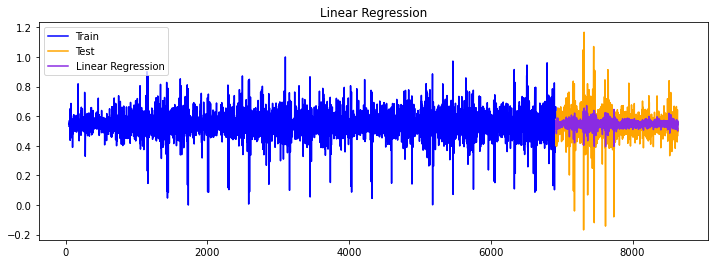

In [18]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_virtual_core_count'], label='Train', color="b")
plt.plot(test['vm_virtual_core_count'], label='Test', color="orange")
plt.plot(test['lr_pred'], label='Linear Regression', color="blueviolet")
plt.legend(loc='best')
plt.title('Linear Regression')
plt.show()

In [19]:
rw48_results = pd.DataFrame({'Method':['Baseline'], 'MAE': [mean_absolute_error(test["vm_virtual_core_count"], test["baseline"])],'RMSE': [np.sqrt(mean_squared_error(test['vm_virtual_core_count'], test['baseline']))] })

In [20]:
lr_mape = mean_absolute_error(test["vm_virtual_core_count"], test["lr_pred"])
lr_rmse = np.sqrt(mean_squared_error(test['vm_virtual_core_count'], test['lr_pred']))

lr_results = pd.DataFrame({'Method':['Linear Regression'], 'MAE': [lr_mape],'RMSE': [lr_rmse] })
rw48_results = pd.concat([rw48_results, lr_results])
rw48_results.head()

,Method,MAE,RMSE
0,Baseline,0.069779,0.105050
0,Linear Regression,0.054324,0.082333


### Decision Tree

In [21]:
dt_reg = DecisionTreeRegressor(random_state=42)


param_search = {'max_depth' : [3, 5, 8, 100], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson']}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=dt_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'max_depth': 3}
0.007799519142911104


In [26]:
dt_reg = DecisionTreeRegressor(criterion='friedman_mse', max_depth=3, random_state=42)
dt_reg.fit(X=x_train, y=y_train)
dt_pred = dt_reg.predict(x_test)
test['dt_pred'] = list(dt_pred)[1:]

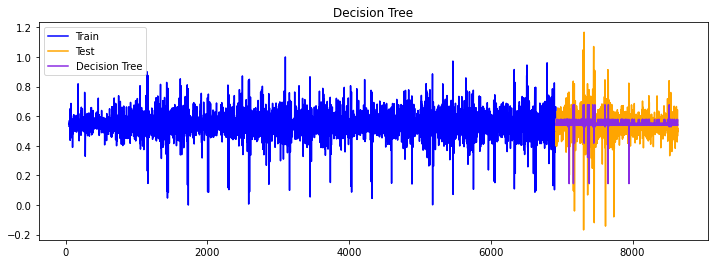

In [27]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_virtual_core_count'], label='Train', color="b")
plt.plot(test['vm_virtual_core_count'], label='Test', color="orange")
plt.plot(test['dt_pred'], label='Decision Tree', color="blueviolet")
plt.legend(loc='best')
plt.title('Decision Tree')
plt.show()

In [28]:
dt_mape = mean_absolute_error(test["vm_virtual_core_count"], test["dt_pred"])
dt_rmse = np.sqrt(mean_squared_error(test['vm_virtual_core_count'], test['dt_pred']))

dt_results = pd.DataFrame({'Method':['Decision Tree'], 'MAE': [dt_mape],'RMSE': [dt_rmse] })
rw48_results = pd.concat([rw48_results, dt_results])
rw48_results.head()

,Method,MAE,RMSE
0,Baseline,0.069779,0.105050
0,Linear Regression,0.054324,0.082333
0,Decision Tree,0.054185,0.084496


### Random Forest

In [22]:
rf_reg = RandomForestRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson'],
               'bootstrap':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=rf_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 5}
0.0877021093136251


In [29]:
rf = RandomForestRegressor(bootstrap=True, criterion='friedman_mse', max_depth=5)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
test["rf_pred"] = rf_pred[1:]

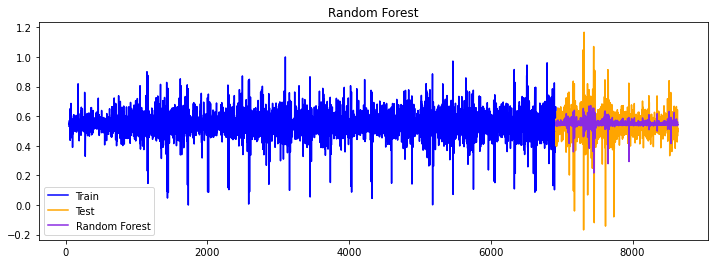

In [30]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_virtual_core_count'], label='Train', color="b")
plt.plot(test['vm_virtual_core_count'], label='Test', color="orange")
plt.plot(test['rf_pred'], label='Random Forest', color="blueviolet")
plt.legend(loc='best')
plt.title('Random Forest')
plt.show()

In [31]:
rf_mape = mean_absolute_error(test["vm_virtual_core_count"], test["rf_pred"])
rf_rmse = np.sqrt(mean_squared_error(test['vm_virtual_core_count'], test['rf_pred']))

rf_results = pd.DataFrame({'Method':['Random Forest'], 'MAE': [rf_mape],'RMSE': [rf_rmse] })
rw48_results = pd.concat([rw48_results, rf_results])
rw48_results.head()

,Method,MAE,RMSE
0,Baseline,0.069779,0.105050
0,Linear Regression,0.054324,0.082333
0,Decision Tree,0.054185,0.084496
0,Random Forest,0.054079,0.081993


### Gradient Boosting

In [23]:
gb_reg = GradientBoostingRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'loss' :['squared_error', 'absolute_error', 'huber', 'quantile'],
                'criterion': ['friedman_mse', 'squared_error'], 'n_estimators':[100, 200, 300], 'max_depth':[3, 5, 8]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=gb_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'loss': 'huber', 'max_depth': 3, 'n_estimators': 100}
0.12052513079544475


In [17]:
gb = GradientBoostingRegressor(criterion='friedman_mse', loss='huber', max_depth=3, n_estimators= 100, random_state=42)
gb.fit(x_train, y=y_train.ravel())
gb_pred = gb.predict(x_test)
test['gb_pred'] = gb_pred[1:]

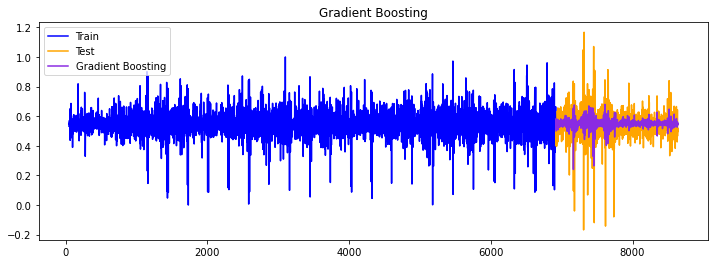

In [18]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_virtual_core_count'], label='Train', color="b")
plt.plot(test['vm_virtual_core_count'], label='Test', color="orange")
plt.plot(test['gb_pred'], label='Gradient Boosting', color="blueviolet")
plt.legend(loc='best')
plt.title('Gradient Boosting')
plt.show()

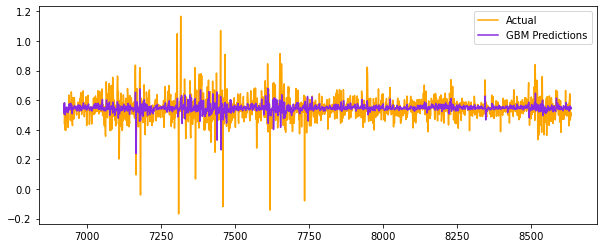

In [21]:
plt.figure(figsize=(10,4))
plt.plot(test['vm_virtual_core_count'], label='Actual', color="orange")
plt.plot(test['gb_pred'], label='GBM Predictions', color="blueviolet")
plt.legend(loc='best')
plt.show()

In [34]:
gb_mape = mean_absolute_error(test["vm_virtual_core_count"], test["gb_pred"])
gb_rmse = np.sqrt(mean_squared_error(test['vm_virtual_core_count'], test['gb_pred']))

gb_results = pd.DataFrame({'Method':['Gradient Boosting'], 'MAE': [gb_mape],'RMSE': [gb_rmse] })
rw48_results = pd.concat([rw48_results, gb_results])
rw48_results

,Method,MAE,RMSE
0,Baseline,0.069779,0.105050
0,Linear Regression,0.054324,0.082333
0,Decision Tree,0.054185,0.084496
0,Random Forest,0.054079,0.081993
0,Gradient Boosting,0.053457,0.080499


### KNN

In [24]:
knn_reg = KNeighborsRegressor(n_neighbors=2)

param_search = {'n_neighbors' : [3, 5, 8, 10], 'weights': ['uniform', 'distance'], 
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=knn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'uniform'}
0.013374223268131924


In [35]:
knn_model = KNeighborsRegressor(algorithm='auto', n_neighbors=10, weights="uniform")
knn_fit = knn_model.fit(x_train, y_train)
test["knn_pred"] = knn_fit.predict(x_test)[1:]

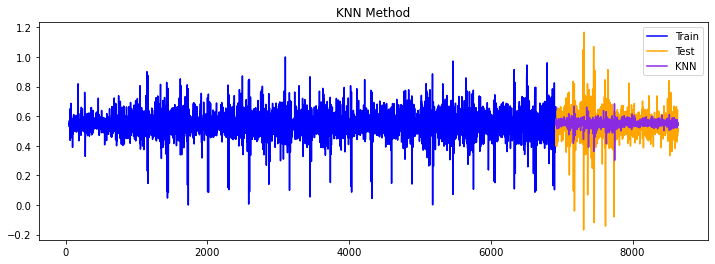

In [36]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_virtual_core_count'], label='Train', color="b")
plt.plot(test['vm_virtual_core_count'], label='Test', color="orange")
plt.plot(test['knn_pred'], label='KNN', color="blueviolet")
plt.legend(loc='best')
plt.title('KNN Method')
plt.show()

In [37]:
knn_mape = mean_absolute_error(test["vm_virtual_core_count"], test["knn_pred"])
knn_rmse = np.sqrt(mean_squared_error(test['vm_virtual_core_count'], test['knn_pred']))

knn_results = pd.DataFrame({'Method':['KNN'], 'MAE': [knn_mape],'RMSE': [knn_rmse] })
rw48_results = pd.concat([rw48_results, knn_results])
rw48_results

,Method,MAE,RMSE
0,Baseline,0.069779,0.105050
0,Linear Regression,0.054324,0.082333
0,Decision Tree,0.054185,0.084496
0,Random Forest,0.054079,0.081993
0,Gradient Boosting,0.053457,0.080499
0,KNN,0.056294,0.084627


### Neural Network

In [25]:
nn_reg = MLPRegressor(random_state=1, max_iter=500)

param_search = {'hidden_layer_sizes' : [100, 150, 200], 'activation':['identity', 'logistic', 'tanh', 'relu'],
                'solver': ['lbfgs', 'sgd', 'adam'], 'learning_rate':['constant', 'invscaling', 'adaptive'],
                'max_iter':[200, 350, 500]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=nn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'activation': 'tanh', 'hidden_layer_sizes': 200, 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'lbfgs'}
0.07074764773956527


In [38]:
nn_model = MLPRegressor(random_state=1, activation='tanh', hidden_layer_sizes=200, learning_rate='constant',
                        max_iter=200, solver='lbfgs')
nn_fit = nn_model.fit(x_train, y_train)
test["nn_pred"] = nn_fit.predict(x_test)[1:]

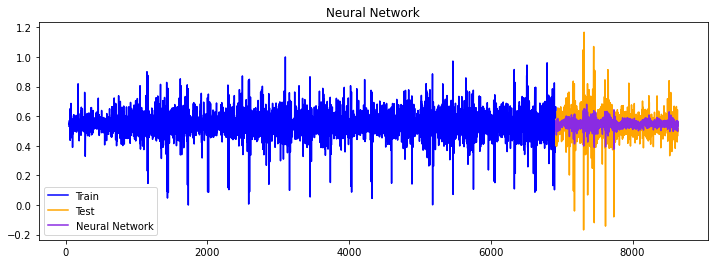

In [39]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_virtual_core_count'], label='Train', color="b")
plt.plot(test['vm_virtual_core_count'], label='Test', color="orange")
plt.plot(test['nn_pred'], label='Neural Network', color="blueviolet")
plt.legend(loc='best')
plt.title('Neural Network')
plt.show()

In [40]:
nn_mape = mean_absolute_error(test["vm_virtual_core_count"], test["nn_pred"])
nn_rmse = np.sqrt(mean_squared_error(test['vm_virtual_core_count'], test['nn_pred']))

nn_results = pd.DataFrame({'Method':['Neural Network'], 'MAE': [nn_mape],'RMSE': [nn_rmse] })
rw48_results = pd.concat([rw48_results, nn_results])
rw48_results

,Method,MAE,RMSE
0,Baseline,0.069779,0.105050
0,Linear Regression,0.054324,0.082333
0,Decision Tree,0.054185,0.084496
0,Random Forest,0.054079,0.081993
0,Gradient Boosting,0.053457,0.080499
0,KNN,0.056294,0.084627
0,Neural Network,0.054528,0.082723


### Simple Moving Average

In [41]:
test["sma_pred"] = list(test[col_names].mean(axis=1))[1:] + [0]

In [42]:
test = test.drop(test.tail(1).index) # Drop last row

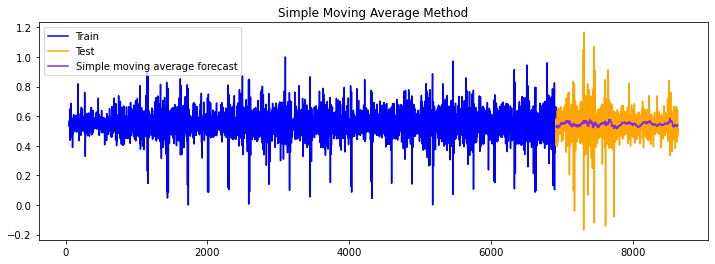

In [43]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_virtual_core_count'], label='Train', color="b")
plt.plot(test['vm_virtual_core_count'], label='Test', color="orange")
plt.plot(test['sma_pred'], label='Simple moving average forecast', color="blueviolet")
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [44]:
sma_mape = mean_absolute_error(test["vm_virtual_core_count"], test["sma_pred"])
sma_rmse = np.sqrt(mean_squared_error(test['vm_virtual_core_count'], test['sma_pred']))

sma_results = pd.DataFrame({'Method':['Simple Moving Avg.'], 'MAE': [sma_mape],'RMSE': [sma_rmse] })
rw48_results = pd.concat([rw48_results, sma_results])
rw48_results

,Method,MAE,RMSE
0,Baseline,0.069779,0.105050
0,Linear Regression,0.054324,0.082333
0,Decision Tree,0.054185,0.084496
0,Random Forest,0.054079,0.081993
0,Gradient Boosting,0.053457,0.080499
0,KNN,0.056294,0.084627
0,Neural Network,0.054528,0.082723
0,Simple Moving Avg.,0.054122,0.083460


## Window Length: 24 (2 hours)

In [45]:
window = 24

rw24_predictions = rw48_predictions[["index", "vm_virtual_core_count", "x25", "x26", "x27", "x28", "x29", "x30", "x31", "x32",
                                    "x33", "x34", "x35", "x36", "x37", "x38", "x39", "x40", "x41", "x42", "x43", 
                                    "x44", "x45", "x46", "x47", "x48"]]
rw24_predictions.head()

,index,vm_virtual_core_count,x25,x26,x27,x28,x29,x30,x31,x32,...,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48
49,2016-11-16 04:10:00,-146.0,-492.0,-653.0,547.0,271.0,807.0,468.0,-895.0,-11.0,...,31.0,-107.0,-126.0,23.0,-178.0,-21.0,83.0,-166.0,-273.0,-106.0
50,2016-11-16 04:15:00,-106.0,-653.0,547.0,271.0,807.0,468.0,-895.0,-11.0,-101.0,...,-107.0,-126.0,23.0,-178.0,-21.0,83.0,-166.0,-273.0,-106.0,-146.0
51,2016-11-16 04:20:00,-102.0,547.0,271.0,807.0,468.0,-895.0,-11.0,-101.0,106.0,...,-126.0,23.0,-178.0,-21.0,83.0,-166.0,-273.0,-106.0,-146.0,-106.0
52,2016-11-16 04:25:00,8.0,271.0,807.0,468.0,-895.0,-11.0,-101.0,106.0,-202.0,...,23.0,-178.0,-21.0,83.0,-166.0,-273.0,-106.0,-146.0,-106.0,-102.0
53,2016-11-16 04:30:00,129.0,807.0,468.0,-895.0,-11.0,-101.0,106.0,-202.0,-70.0,...,-178.0,-21.0,83.0,-166.0,-273.0,-106.0,-146.0,-106.0,-102.0,8.0


In [46]:
train, test = train_test_split(rw24_predictions, test_size = 0.2, random_state= 1, shuffle=False)
train.shape, test.shape

((6871, 26), (1718, 26))

# Normalise the data

In [47]:
col_names = ["x25", "x26", "x27", "x28", "x29", "x30", "x31", "x32", "x33", "x34", "x35", "x36", "x37", "x38", "x39", "x40","x41", "x42", "x43", "x44", "x45", "x46", "x47", "x48"]

In [48]:
scaler = MinMaxScaler()
train[["vm_virtual_core_count"] + col_names] = scaler.fit_transform(train[["vm_virtual_core_count"] + col_names])
test[["vm_virtual_core_count"] + col_names] = scaler.transform(test[["vm_virtual_core_count"] + col_names])

In [49]:
x_train, x_test, y_train, y_test = train_test_split(rw24_predictions[col_names].values, rw24_predictions['vm_virtual_core_count'].values, test_size=0.2, random_state=42, shuffle=False)

In [50]:
x_train = train[col_names]
y_train = train["vm_virtual_core_count"]
x_test = test[col_names]
y_test = test["vm_virtual_core_count"]

## Prediction Models
Two step ahead prediction. One Step ahead prediction would not allow for the necessary provisions to be made in real world situations
### Baseline

In [51]:
test["baseline"] = test[["vm_virtual_core_count"]].shift(1)
test = test.drop(test.head(1).index)
test.head()

,index,vm_virtual_core_count,x25,x26,x27,x28,x29,x30,x31,x32,...,x40,x41,x42,x43,x44,x45,x46,x47,x48,baseline
6921,2016-12-10 00:50:00,0.508035,0.721234,0.103064,0.508035,0.462717,0.355046,0.483608,0.583780,0.515213,...,0.598993,0.486715,0.664024,0.575423,0.576602,0.532141,0.522927,0.579173,0.649239,0.649239
6922,2016-12-10 00:55:00,0.581530,0.103064,0.508035,0.462717,0.355046,0.483608,0.583780,0.515213,0.493893,...,0.486715,0.664024,0.575423,0.576602,0.532141,0.522927,0.579173,0.649239,0.508035,0.508035
6923,2016-12-10 01:00:00,0.437862,0.508035,0.462717,0.355046,0.483608,0.583780,0.515213,0.493893,0.594600,...,0.664024,0.575423,0.576602,0.532141,0.522927,0.579173,0.649239,0.508035,0.581530,0.581530
6924,2016-12-10 01:05:00,0.492501,0.462717,0.355046,0.483608,0.583780,0.515213,0.493893,0.594600,0.498179,...,0.575423,0.576602,0.532141,0.522927,0.579173,0.649239,0.508035,0.581530,0.437862,0.437862
6925,2016-12-10 01:10:00,0.398972,0.355046,0.483608,0.583780,0.515213,0.493893,0.594600,0.498179,0.579601,...,0.576602,0.532141,0.522927,0.579173,0.649239,0.508035,0.581530,0.437862,0.492501,0.492501


### Linear Regression

In [52]:
linear_reg = LinearRegression()


param_search = {'fit_intercept':[True, False], 'positive':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=linear_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'fit_intercept': True, 'positive': False}
0.06820526400032806


In [53]:
lin_reg = LinearRegression(fit_intercept=True, positive=False)
lin_reg.fit(x_train, y_train)
lr_pred = lin_reg.predict(x_test)
test["lr_pred"] = lr_pred[1:]

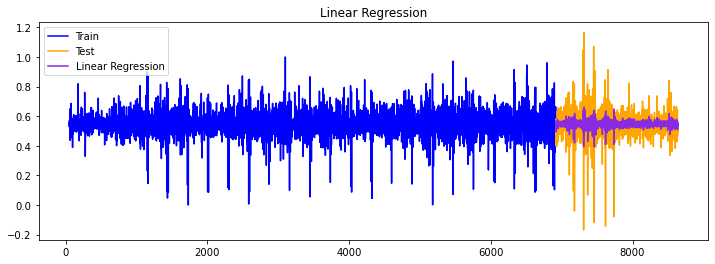

In [54]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_virtual_core_count'], label='Train', color="b")
plt.plot(test['vm_virtual_core_count'], label='Test', color="orange")
plt.plot(test['lr_pred'], label='Linear Regression', color="blueviolet")
plt.legend(loc='best')
plt.title('Linear Regression')
plt.show()

In [55]:
rw24_results = pd.DataFrame({'Method':['Baseline'], 'MAE': [mean_absolute_error(test["vm_virtual_core_count"], test["baseline"])],'RMSE': [np.sqrt(mean_squared_error(test['vm_virtual_core_count'], test['baseline']))] })

In [56]:
lr_mape = mean_absolute_error(test["vm_virtual_core_count"], test["lr_pred"])
lr_rmse = np.sqrt(mean_squared_error(test['vm_virtual_core_count'], test['lr_pred']))

lr_results = pd.DataFrame({'Method':['Linear Regression'], 'MAE': [lr_mape],'RMSE': [lr_rmse] })
rw24_results = pd.concat([rw24_results, lr_results])
rw24_results.head()

,Method,MAE,RMSE
0,Baseline,0.069779,0.105050
0,Linear Regression,0.054410,0.082423


### Decision Tree

In [57]:
dt_reg = DecisionTreeRegressor(random_state=42)


param_search = {'max_depth' : [3, 5, 8, 100], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson']}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=dt_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'max_depth': 3}
0.019386553778964755


In [63]:
dt_reg = DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,random_state=42)
dt_reg.fit(X=x_train, y=y_train)
dt_pred = dt_reg.predict(x_test)
test['dt_pred'] = list(dt_pred)[1:]

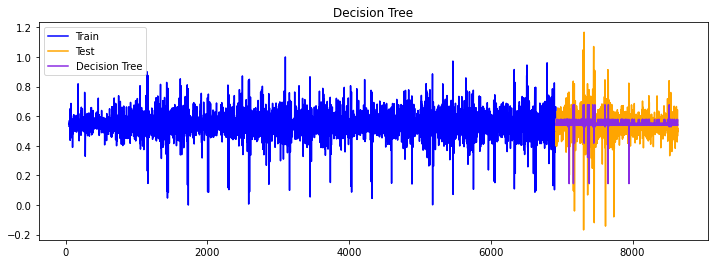

In [64]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_virtual_core_count'], label='Train', color="b")
plt.plot(test['vm_virtual_core_count'], label='Test', color="orange")
plt.plot(test['dt_pred'], label='Decision Tree', color="blueviolet")
plt.legend(loc='best')
plt.title('Decision Tree')
plt.show()

In [65]:
dt_mape = mean_absolute_error(test["vm_virtual_core_count"], test["dt_pred"])
dt_rmse = np.sqrt(mean_squared_error(test['vm_virtual_core_count'], test['dt_pred']))

dt_results = pd.DataFrame({'Method':['Decision Tree'], 'MAE': [dt_mape],'RMSE': [dt_rmse] })
rw24_results = pd.concat([rw24_results, dt_results])
rw24_results.head()

,Method,MAE,RMSE
0,Baseline,0.069779,0.105050
0,Linear Regression,0.054410,0.082423
0,Decision Tree,0.054185,0.084496


### Random Forest

In [58]:
rf_reg = RandomForestRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson'],
               'bootstrap':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=rf_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 8}
0.09695740089593352


In [66]:
rf = RandomForestRegressor(bootstrap=True, criterion='friedman_mse', max_depth=8)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
test["rf_pred"] = rf_pred[1:]

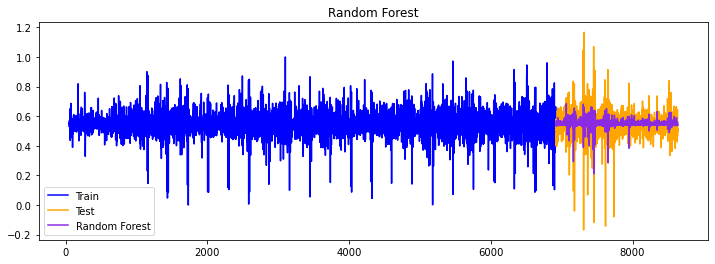

In [67]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_virtual_core_count'], label='Train', color="b")
plt.plot(test['vm_virtual_core_count'], label='Test', color="orange")
plt.plot(test['rf_pred'], label='Random Forest', color="blueviolet")
plt.legend(loc='best')
plt.title('Random Forest')
plt.show()

In [68]:
rf_mape = mean_absolute_error(test["vm_virtual_core_count"], test["rf_pred"])
rf_rmse = np.sqrt(mean_squared_error(test['vm_virtual_core_count'], test['rf_pred']))

rf_results = pd.DataFrame({'Method':['Random Forest'], 'MAE': [rf_mape],'RMSE': [rf_rmse] })
rw24_results = pd.concat([rw24_results, rf_results])
rw24_results.head()

,Method,MAE,RMSE
0,Baseline,0.069779,0.105050
0,Linear Regression,0.054410,0.082423
0,Decision Tree,0.054185,0.084496
0,Random Forest,0.054333,0.082019


### Gradient Boosting

In [59]:
gb_reg = GradientBoostingRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'loss' :['squared_error', 'absolute_error', 'huber', 'quantile'],
                'criterion': ['friedman_mse', 'squared_error'], 'n_estimators':[100, 200, 300], 'max_depth':[3, 5, 8]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=gb_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'loss': 'huber', 'max_depth': 3, 'n_estimators': 100}
0.10819009458650874


In [69]:
gb = GradientBoostingRegressor(criterion='friedman_mse', loss='huber', max_depth=3, n_estimators=100, random_state=42)
gb.fit(x_train, y=y_train.ravel())
gb_pred = gb.predict(x_test)
test['gb_pred'] = gb_pred[1:]

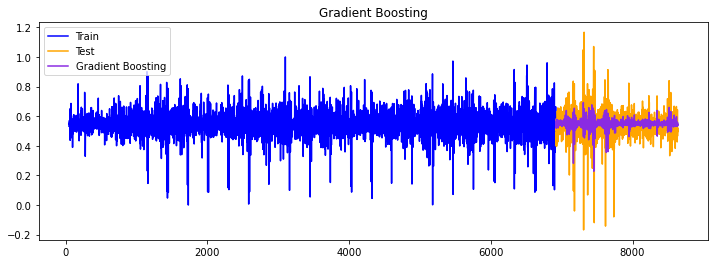

In [70]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_virtual_core_count'], label='Train', color="b")
plt.plot(test['vm_virtual_core_count'], label='Test', color="orange")
plt.plot(test['gb_pred'], label='Gradient Boosting', color="blueviolet")
plt.legend(loc='best')
plt.title('Gradient Boosting')
plt.show()

In [71]:
gb_mape = mean_absolute_error(test["vm_virtual_core_count"], test["gb_pred"])
gb_rmse = np.sqrt(mean_squared_error(test['vm_virtual_core_count'], test['gb_pred']))

gb_results = pd.DataFrame({'Method':['Gradient Boosting'], 'MAE': [gb_mape],'RMSE': [gb_rmse] })
rw24_results = pd.concat([rw24_results, gb_results])
rw24_results

,Method,MAE,RMSE
0,Baseline,0.069779,0.105050
0,Linear Regression,0.054410,0.082423
0,Decision Tree,0.054185,0.084496
0,Random Forest,0.054333,0.082019
0,Gradient Boosting,0.053803,0.080908


### KNN

In [60]:
knn_reg = KNeighborsRegressor(n_neighbors=2)

param_search = {'n_neighbors' : [3, 5, 8, 10], 'weights': ['uniform', 'distance'], 
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=knn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'uniform'}
0.018215951527436824


In [72]:
knn_model = KNeighborsRegressor(algorithm='auto', n_neighbors=10, weights="uniform")
knn_fit = knn_model.fit(x_train, y_train)
test["knn_pred"] = knn_fit.predict(x_test)[1:]

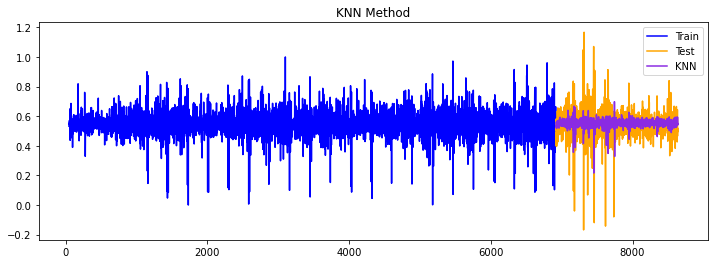

In [73]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_virtual_core_count'], label='Train', color="b")
plt.plot(test['vm_virtual_core_count'], label='Test', color="orange")
plt.plot(test['knn_pred'], label='KNN', color="blueviolet")
plt.legend(loc='best')
plt.title('KNN Method')
plt.show()

In [74]:
knn_mape = mean_absolute_error(test["vm_virtual_core_count"], test["knn_pred"])
knn_rmse = np.sqrt(mean_squared_error(test['vm_virtual_core_count'], test['knn_pred']))

knn_results = pd.DataFrame({'Method':['KNN'], 'MAE': [knn_mape],'RMSE': [knn_rmse] })
rw24_results = pd.concat([rw24_results, knn_results])
rw24_results

,Method,MAE,RMSE
0,Baseline,0.069779,0.105050
0,Linear Regression,0.054410,0.082423
0,Decision Tree,0.054185,0.084496
0,Random Forest,0.054333,0.082019
0,Gradient Boosting,0.053803,0.080908
0,KNN,0.056542,0.084393


### Neural Network

In [61]:
nn_reg = MLPRegressor(random_state=1, max_iter=500)

param_search = {'hidden_layer_sizes' : [100, 150, 200], 'activation':['identity', 'logistic', 'tanh', 'relu'],
                'solver': ['lbfgs', 'sgd', 'adam'], 'learning_rate':['constant', 'invscaling', 'adaptive'],
                'max_iter':[200, 350, 500]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=nn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'activation': 'relu', 'hidden_layer_sizes': 150, 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'lbfgs'}
0.0781104121304092


In [75]:
nn_model = MLPRegressor(random_state=1, activation='relu', hidden_layer_sizes=150, learning_rate='constant', 
                        max_iter=200, solver='lbfgs')
nn_fit = nn_model.fit(x_train, y_train)
test["nn_pred"] = nn_fit.predict(x_test)[1:]

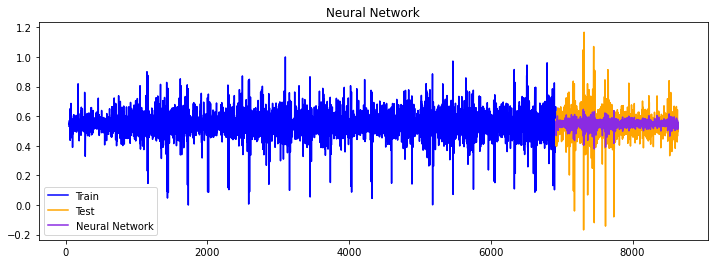

In [76]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_virtual_core_count'], label='Train', color="b")
plt.plot(test['vm_virtual_core_count'], label='Test', color="orange")
plt.plot(test['nn_pred'], label='Neural Network', color="blueviolet")
plt.legend(loc='best')
plt.title('Neural Network')
plt.show()

In [77]:
nn_mape = mean_absolute_error(test["vm_virtual_core_count"], test["nn_pred"])
nn_rmse = np.sqrt(mean_squared_error(test['vm_virtual_core_count'], test['nn_pred']))

nn_results = pd.DataFrame({'Method':['Neural Network'], 'MAE': [nn_mape],'RMSE': [nn_rmse] })
rw24_results = pd.concat([rw24_results, nn_results])
rw24_results

,Method,MAE,RMSE
0,Baseline,0.069779,0.105050
0,Linear Regression,0.054410,0.082423
0,Decision Tree,0.054185,0.084496
0,Random Forest,0.054333,0.082019
0,Gradient Boosting,0.053803,0.080908
0,KNN,0.056542,0.084393
0,Neural Network,0.054721,0.082718


### Simple Moving Average

In [62]:
test["sma_pred"] = list(test[col_names].mean(axis=1))[1:] +[0]

In [78]:
test = test.drop(test.tail(1).index) # Drop last row

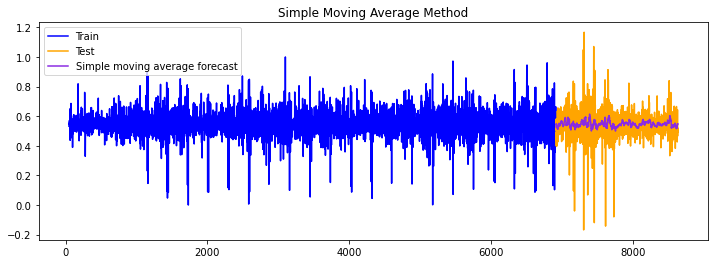

In [79]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_virtual_core_count'], label='Train', color="b")
plt.plot(test['vm_virtual_core_count'], label='Test', color="orange")
plt.plot(test['sma_pred'], label='Simple moving average forecast', color="blueviolet")
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [80]:
sma_mape = mean_absolute_error(test["vm_virtual_core_count"], test["sma_pred"])
sma_rmse = np.sqrt(mean_squared_error(test['vm_virtual_core_count'], test['sma_pred']))

sma_results = pd.DataFrame({'Method':['Simple Moving Avg.'], 'MAE': [sma_mape],'RMSE': [sma_rmse] })
rw24_results = pd.concat([rw24_results, sma_results])
rw24_results

,Method,MAE,RMSE
0,Baseline,0.069779,0.105050
0,Linear Regression,0.054410,0.082423
0,Decision Tree,0.054185,0.084496
0,Random Forest,0.054333,0.082019
0,Gradient Boosting,0.053803,0.080908
0,KNN,0.056542,0.084393
0,Neural Network,0.054721,0.082718
0,Simple Moving Avg.,0.053914,0.082787


## Window Length: 12 (60 minutes)

In [81]:
col_names = ["x37", "x38", "x39", "x40", "x41", "x42", "x43", "x44", "x45", "x46", "x47", "x48"]

In [82]:
window = 12

rw12_predictions = rw48_predictions[["index", "vm_virtual_core_count", "x37", "x38", "x39", "x40", "x41", "x42", "x43", 
                                    "x44", "x45", "x46", "x47", "x48"]]
rw12_predictions.head()

,index,vm_virtual_core_count,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48
49,2016-11-16 04:10:00,-146.0,-268.0,-357.0,31.0,-107.0,-126.0,23.0,-178.0,-21.0,83.0,-166.0,-273.0,-106.0
50,2016-11-16 04:15:00,-106.0,-357.0,31.0,-107.0,-126.0,23.0,-178.0,-21.0,83.0,-166.0,-273.0,-106.0,-146.0
51,2016-11-16 04:20:00,-102.0,31.0,-107.0,-126.0,23.0,-178.0,-21.0,83.0,-166.0,-273.0,-106.0,-146.0,-106.0
52,2016-11-16 04:25:00,8.0,-107.0,-126.0,23.0,-178.0,-21.0,83.0,-166.0,-273.0,-106.0,-146.0,-106.0,-102.0
53,2016-11-16 04:30:00,129.0,-126.0,23.0,-178.0,-21.0,83.0,-166.0,-273.0,-106.0,-146.0,-106.0,-102.0,8.0


In [83]:
train, test = train_test_split(rw12_predictions, test_size = 0.2, random_state= 1, shuffle=False)
train.shape, test.shape

((6871, 14), (1718, 14))

# Normalise the data

In [84]:
scaler = MinMaxScaler()
train[["vm_virtual_core_count"] + col_names] = scaler.fit_transform(train[["vm_virtual_core_count"] + col_names])
test[["vm_virtual_core_count"] + col_names] = scaler.transform(test[["vm_virtual_core_count"] + col_names])

In [85]:
x_train, x_test, y_train, y_test = train_test_split(rw48_predictions[col_names].values, rw48_predictions['vm_virtual_core_count'].values, test_size=0.2, random_state=42, shuffle=False)

In [86]:
x_train = train[col_names]
y_train = train["vm_virtual_core_count"]
x_test = test[col_names]
y_test = test["vm_virtual_core_count"]

## Prediction Models
Two step ahead prediction. One Step ahead prediction would not allow for the necessary provisions to be made in real world situations
### Baseline

In [87]:
test["baseline"] = test[["vm_virtual_core_count"]].shift(1) # for step ahead prediction
test = test.drop(test.head(1).index) # Drop first row as it has no baseline predictor

### Linear Regression

In [88]:
linear_reg = LinearRegression()


param_search = {'fit_intercept':[True, False], 'positive':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=linear_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'fit_intercept': True, 'positive': False}
0.06128363402959608


In [89]:
lin_reg = LinearRegression(fit_intercept=True, positive=False)
lin_reg.fit(x_train, y_train)
lr_pred = lin_reg.predict(x_test)
test["lr_pred"] = lr_pred[1:]

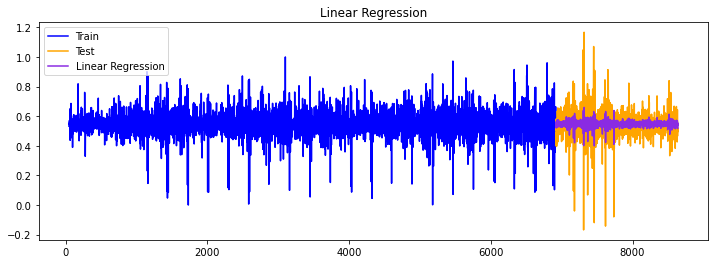

In [90]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_virtual_core_count'], label='Train', color="b")
plt.plot(test['vm_virtual_core_count'], label='Test', color="orange")
plt.plot(test['lr_pred'], label='Linear Regression', color="blueviolet")
plt.legend(loc='best')
plt.title('Linear Regression')
plt.show()

In [91]:
rw12_results = pd.DataFrame({'Method':['Baseline'], 'MAE': [mean_absolute_error(test["vm_virtual_core_count"], test["baseline"])],'RMSE': [np.sqrt(mean_squared_error(test['vm_virtual_core_count'], test['baseline']))] })

In [92]:
lr_mape = mean_absolute_error(test["vm_virtual_core_count"], test["lr_pred"])
lr_rmse = np.sqrt(mean_squared_error(test['vm_virtual_core_count'], test['lr_pred']))

lr_results = pd.DataFrame({'Method':['Linear Regression'], 'MAE': [lr_mape],'RMSE': [lr_rmse] })
rw12_results = pd.concat([rw12_results, lr_results])
rw12_results.head()

,Method,MAE,RMSE
0,Baseline,0.069779,0.105050
0,Linear Regression,0.054375,0.082613


### Decision Tree

In [93]:
dt_reg = DecisionTreeRegressor(random_state=42)


param_search = {'max_depth' : [3, 5, 8, 100], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson']}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=dt_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'max_depth': 3}
0.009743595231475999


In [94]:
dt_reg = DecisionTreeRegressor(criterion='friedman_mse', max_depth=3, random_state=42)
dt_reg.fit(X=x_train, y=y_train)
dt_pred = dt_reg.predict(x_test)
test['dt_pred'] = list(dt_pred)[1:]

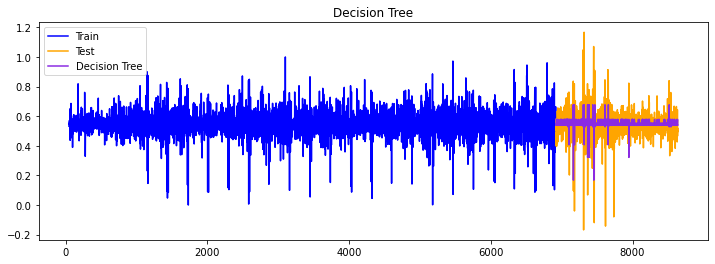

In [95]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_virtual_core_count'], label='Train', color="b")
plt.plot(test['vm_virtual_core_count'], label='Test', color="orange")
plt.plot(test['dt_pred'], label='Decision Tree', color="blueviolet")
plt.legend(loc='best')
plt.title('Decision Tree')
plt.show()

In [96]:
dt_mape = mean_absolute_error(test["vm_virtual_core_count"], test["dt_pred"])
dt_rmse = np.sqrt(mean_squared_error(test['vm_virtual_core_count'], test['dt_pred']))

dt_results = pd.DataFrame({'Method':['Decision Tree'], 'MAE': [dt_mape],'RMSE': [dt_rmse] })
rw12_results = pd.concat([rw12_results, dt_results])
rw12_results.head()

,Method,MAE,RMSE
0,Baseline,0.069779,0.105050
0,Linear Regression,0.054375,0.082613
0,Decision Tree,0.053753,0.082416


### Random Forest

In [97]:
rf_reg = RandomForestRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'criterion': ['squared_error', 'friedman_mse','absolute_error', 'poisson'],
               'bootstrap':[True, False]}

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=rf_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'bootstrap': True, 'criterion': 'friedman_mse', 'max_depth': 5}
0.088080013397077


In [101]:
rf = RandomForestRegressor(bootstrap=True, criterion='friedman_mse', max_depth=5)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
test["rf_pred"] = rf_pred[1:]

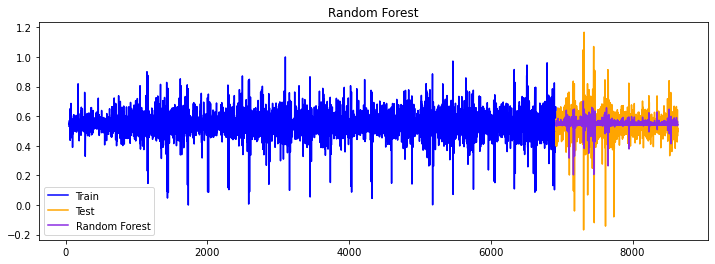

In [102]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_virtual_core_count'], label='Train', color="b")
plt.plot(test['vm_virtual_core_count'], label='Test', color="orange")
plt.plot(test['rf_pred'], label='Random Forest', color="blueviolet")
plt.legend(loc='best')
plt.title('Random Forest')
plt.show()

In [103]:
rf_mape = mean_absolute_error(test["vm_virtual_core_count"], test["rf_pred"])
rf_rmse = np.sqrt(mean_squared_error(test['vm_virtual_core_count'], test['rf_pred']))

rf_results = pd.DataFrame({'Method':['Random Forest'], 'MAE': [rf_mape],'RMSE': [rf_rmse] })
rw12_results = pd.concat([rw12_results, rf_results])
rw12_results.head()

,Method,MAE,RMSE
0,Baseline,0.069779,0.105050
0,Linear Regression,0.054375,0.082613
0,Decision Tree,0.053753,0.082416
0,Random Forest,0.054292,0.081977


### Gradient Boosting

In [98]:
gb_reg = GradientBoostingRegressor(random_state=42)

param_search = {'max_depth' : [3, 5, 8], 'loss' :['squared_error', 'absolute_error', 'huber', 'quantile'],
                'criterion': ['friedman_mse', 'squared_error'], 'n_estimators':[100, 200, 300], 'max_depth':[3, 5, 8]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=gb_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'criterion': 'friedman_mse', 'loss': 'huber', 'max_depth': 3, 'n_estimators': 100}
0.10112874165410307


In [104]:
gb = GradientBoostingRegressor(criterion='friedman_mse', loss='huber', max_depth=3, n_estimators=100, random_state=42)
gb.fit(x_train, y=y_train.ravel())
gb_pred = gb.predict(x_test)
test['gb_pred'] = gb_pred[1:]

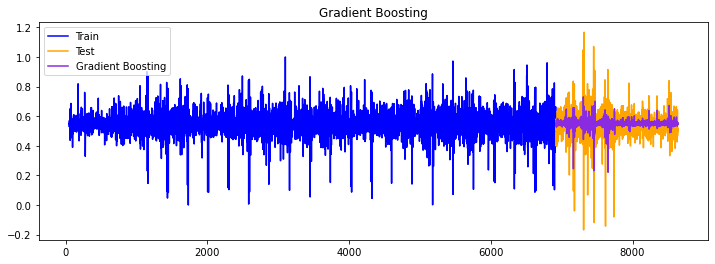

In [105]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_virtual_core_count'], label='Train', color="b")
plt.plot(test['vm_virtual_core_count'], label='Test', color="orange")
plt.plot(test['gb_pred'], label='Gradient Boosting', color="blueviolet")
plt.legend(loc='best')
plt.title('Gradient Boosting')
plt.show()

In [106]:
gb_mape = mean_absolute_error(test["vm_virtual_core_count"], test["gb_pred"])
gb_rmse = np.sqrt(mean_squared_error(test['vm_virtual_core_count'], test['gb_pred']))

gb_results = pd.DataFrame({'Method':['Gradient Boosting'], 'MAE': [gb_mape],'RMSE': [gb_rmse] })
rw12_results = pd.concat([rw12_results, gb_results])
rw12_results

,Method,MAE,RMSE
0,Baseline,0.069779,0.105050
0,Linear Regression,0.054375,0.082613
0,Decision Tree,0.053753,0.082416
0,Random Forest,0.054292,0.081977
0,Gradient Boosting,0.053904,0.081192


### KNN

In [99]:
knn_reg = KNeighborsRegressor(n_neighbors=2)

param_search = {'n_neighbors' : [3, 5, 8, 10], 'weights': ['uniform', 'distance'], 
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=knn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'algorithm': 'auto', 'n_neighbors': 8, 'weights': 'distance'}
0.059353261480406094


In [107]:
knn_model = KNeighborsRegressor(algorithm='auto', n_neighbors=8, weights="distance")
knn_fit = knn_model.fit(x_train, y_train)
test["knn_pred"] = knn_fit.predict(x_test)[1:]

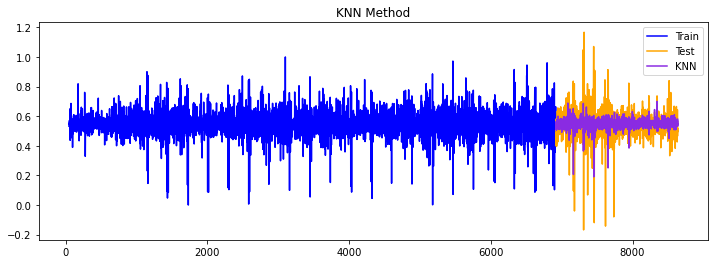

In [108]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_virtual_core_count'], label='Train', color="b")
plt.plot(test['vm_virtual_core_count'], label='Test', color="orange")
plt.plot(test['knn_pred'], label='KNN', color="blueviolet")
plt.legend(loc='best')
plt.title('KNN Method')
plt.show()

In [109]:
knn_mape = mean_absolute_error(test["vm_virtual_core_count"], test["knn_pred"])
knn_rmse = np.sqrt(mean_squared_error(test['vm_virtual_core_count'], test['knn_pred']))

knn_results = pd.DataFrame({'Method':['KNN'], 'MAE': [knn_mape],'RMSE': [knn_rmse] })
rw12_results = pd.concat([rw12_results, knn_results])
rw12_results

,Method,MAE,RMSE
0,Baseline,0.069779,0.105050
0,Linear Regression,0.054375,0.082613
0,Decision Tree,0.053753,0.082416
0,Random Forest,0.054292,0.081977
0,Gradient Boosting,0.053904,0.081192
0,KNN,0.057261,0.085589


### Neural Network

In [100]:
nn_reg = MLPRegressor(random_state=1, max_iter=500)

param_search = {'hidden_layer_sizes' : [100, 150, 200], 'activation':['identity', 'logistic', 'tanh', 'relu'],
                'solver': ['lbfgs', 'sgd', 'adam'], 'learning_rate':['constant', 'invscaling', 'adaptive'],
                'max_iter':[200, 350, 500]
               }

tscv = TimeSeriesSplit(n_splits=2, test_size = 700)

gsearch = GridSearchCV(estimator=nn_reg, cv=tscv,
                        param_grid=param_search)
gsearch.fit(x_train, y_train)
print('The best params are:')
print(gsearch.best_params_)
print(gsearch.best_score_)

The best params are:
{'activation': 'relu', 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'lbfgs'}
0.10374601525702776


In [110]:
nn_model = MLPRegressor(random_state=1, activation='relu', hidden_layer_sizes=100, learning_rate='constant', 
                        max_iter=200, solver='lbfgs' )
nn_fit = nn_model.fit(x_train, y_train)
test["nn_pred"] = nn_fit.predict(x_test)[1:]

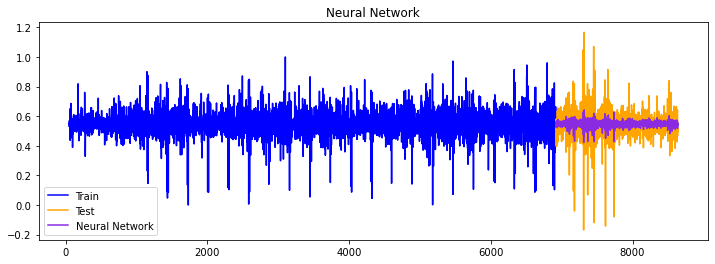

In [111]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_virtual_core_count'], label='Train', color="b")
plt.plot(test['vm_virtual_core_count'], label='Test', color="orange")
plt.plot(test['nn_pred'], label='Neural Network', color="blueviolet")
plt.legend(loc='best')
plt.title('Neural Network')
plt.show()

In [112]:
nn_mape = mean_absolute_error(test["vm_virtual_core_count"], test["nn_pred"])
nn_rmse = np.sqrt(mean_squared_error(test['vm_virtual_core_count'], test['nn_pred']))

nn_results = pd.DataFrame({'Method':['Neural Network'], 'MAE': [nn_mape],'RMSE': [nn_rmse] })
rw12_results = pd.concat([rw12_results, nn_results])
rw12_results

,Method,MAE,RMSE
0,Baseline,0.069779,0.105050
0,Linear Regression,0.054375,0.082613
0,Decision Tree,0.053753,0.082416
0,Random Forest,0.054292,0.081977
0,Gradient Boosting,0.053904,0.081192
0,KNN,0.057261,0.085589
0,Neural Network,0.054438,0.082592


### Simple Moving Average

In [113]:
test["sma_pred"] = list(test[col_names].mean(axis=1))[1:] + [0]

In [114]:
test = test.drop(test.tail(1).index) # Drop last row

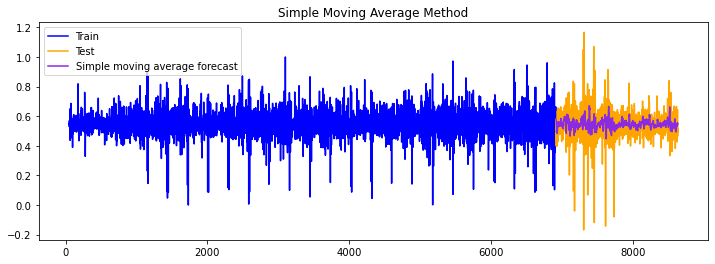

In [115]:
plt.figure(figsize=(12,4))
plt.plot(train['vm_virtual_core_count'], label='Train', color="b")
plt.plot(test['vm_virtual_core_count'], label='Test', color="orange")
plt.plot(test['sma_pred'], label='Simple moving average forecast', color="blueviolet")
plt.legend(loc='best')
plt.title('Simple Moving Average Method')
plt.show()

In [116]:
sma_mape = mean_absolute_error(test["vm_virtual_core_count"], test["sma_pred"])
sma_rmse = np.sqrt(mean_squared_error(test['vm_virtual_core_count'], test['sma_pred']))

sma_results = pd.DataFrame({'Method':['Simple Moving Avg.'], 'MAE': [sma_mape],'RMSE': [sma_rmse] })
rw12_results = pd.concat([rw12_results, sma_results])
rw12_results

,Method,MAE,RMSE
0,Baseline,0.069779,0.105050
0,Linear Regression,0.054375,0.082613
0,Decision Tree,0.053753,0.082416
0,Random Forest,0.054292,0.081977
0,Gradient Boosting,0.053904,0.081192
0,KNN,0.057261,0.085589
0,Neural Network,0.054438,0.082592
0,Simple Moving Avg.,0.052780,0.081337


# Compare Results

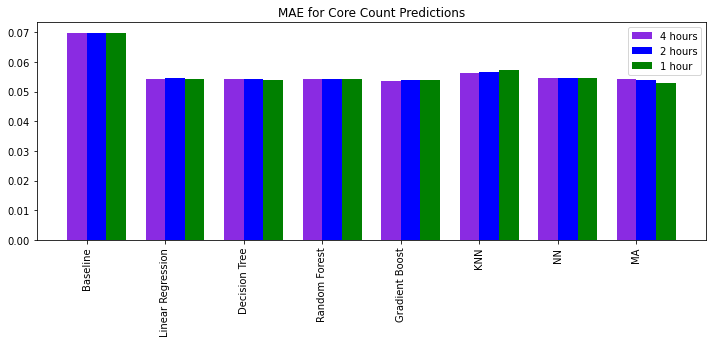

In [117]:
n=8
r = np.arange(n)
width = 0.25

plt.figure(figsize=(12,4))
plt.bar(r, rw48_results["MAE"], width=width, label="4 hours", color="blueviolet")
plt.bar(r+width, rw24_results["MAE"], width=width, label="2 hours", color="b")
plt.bar(r+width+width, rw12_results["MAE"], width=width, label="1 hour", color="green")
plt.legend(loc='best')
plt.title("MAE for Core Count Predictions")
plt.xticks(r + width/2,['Baseline','Linear Regression', 'Decision Tree','Random Forest','Gradient Boost', 'KNN', 'NN','MA'], rotation=90)
plt.show()

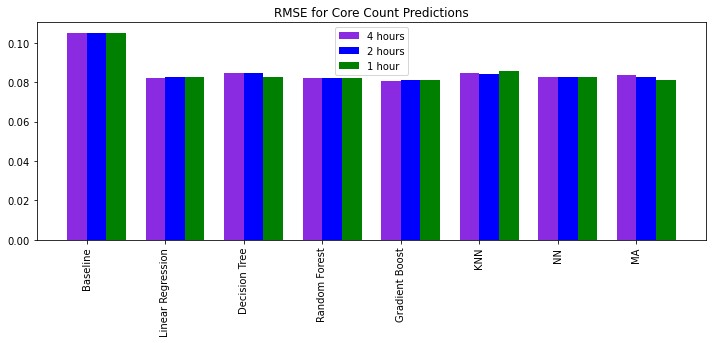

In [118]:
n=8
r = np.arange(n)
width = 0.25

plt.figure(figsize=(12,4))
plt.bar(r, rw48_results["RMSE"], width=width, label="4 hours", color="blueviolet")
plt.bar(r+width, rw24_results["RMSE"], width=width, label="2 hours", color="b")
plt.bar(r+width+width, rw12_results["RMSE"], width=width, label="1 hour", color="green")
plt.legend(loc='best')
plt.title("RMSE for Core Count Predictions")
plt.xticks(r + width/2,['Baseline', 'Linear Regression','Decision Tree','Random Forest','Gradient Boost', 'KNN','NN', 'MA'], rotation=90)
plt.show()

In [119]:
rw48_results = rw48_results.reset_index()
rw24_results = rw24_results.reset_index()
rw12_results = rw12_results.reset_index()

In [120]:
total_results = pd.merge(rw48_results, rw24_results, on='Method', how='outer')
total_results = pd.merge(total_results, rw12_results, on='Method', how='outer')
total_results

,index_x,Method,MAE_x,RMSE_x,index_y,MAE_y,RMSE_y,index,MAE,RMSE
0,0,Baseline,0.069779,0.105050,0,0.069779,0.105050,0,0.069779,0.105050
1,0,Linear Regression,0.054324,0.082333,0,0.054410,0.082423,0,0.054375,0.082613
2,0,Decision Tree,0.054185,0.084496,0,0.054185,0.084496,0,0.053753,0.082416
3,0,Random Forest,0.054079,0.081993,0,0.054333,0.082019,0,0.054292,0.081977
4,0,Gradient Boosting,0.053457,0.080499,0,0.053803,0.080908,0,0.053904,0.081192
5,0,KNN,0.056294,0.084627,0,0.056542,0.084393,0,0.057261,0.085589
6,0,Neural Network,0.054528,0.082723,0,0.054721,0.082718,0,0.054438,0.082592
7,0,Simple Moving Avg.,0.054122,0.083460,0,0.053914,0.082787,0,0.052780,0.081337


In [121]:
total_results = total_results[["Method","MAE_x", "RMSE_x", "MAE_y", "RMSE_y", "MAE", "RMSE"]]

In [122]:
total_results = total_results.rename(columns={total_results.columns[0]: "Methods", 
                              total_results.columns[1]: "MAE (w=48)", total_results.columns[2]: "RMSE (w=48)", 
                              total_results.columns[3]: "M AE (w=24)", total_results.columns[4]: "RMSE (w=24)", 
                              total_results.columns[5]: "MAE (w=12)", total_results.columns[6]: "RMSE (w=12)", 
                            })

In [123]:
total_results.to_csv("C:/Users/user/OneDrive - University College Cork/UCC/Year 4/FYP/Results/corecount_results.csv")